<a href="https://colab.research.google.com/github/adarsh-meher/HE---Predict-Drug/blob/master/HE_Drug_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/adarsh-meher/HE---Predict-Drug.git

fatal: destination path 'HE---Predict-Drug' already exists and is not an empty directory.


In [0]:
import os
os.chdir('/content/HE---Predict-Drug')

In [62]:
import pandas as pd
import numpy as np
import scipy as sc
import nltk
import spacy as S
import gensim as G
import torch
from datetime import datetime as dt
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
import matplotlib.pyplot as plt
import seaborn as sb

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [0]:
train['Date_New'] = train['drug_approved_by_UIC'].apply(lambda x : dt.strptime(x,'%d-%b-%y'))
test['Date_New'] = test['drug_approved_by_UIC'].apply(lambda x : dt.strptime(x,'%d-%b-%y'))

In [0]:
def extract_data_info(data,target_col = None,cols_to_use = None):
  cols = cols_to_use if cols_to_use!=None else data.columns.tolist()
  df = pd.DataFrame(index = range(len(cols)))
  
  for i,c in enumerate(cols):
    df.loc[i,'Column Name'] = c
    df.loc[i,'Column Type'] = data[c].dtype
    df.loc[i,'# Missing'] = data[c].isnull().sum()
    df.loc[i,'# Unique Vals'] = data[c].nunique() 
    df.loc[i,'Total Values'] = data.shape[0]
    df.loc[i,'Max/Modal Val'] = data[c].max() if data[c].dtype != object else train[c].value_counts().index[train[c].value_counts().argmax()]
    df.loc[i,'Min/Low Freq Val'] = data[c].min() if data[c].dtype != object else train[c].value_counts().index[train[c].value_counts().argmin()]
    df.loc[i,'Correaltion with target'] = data[[c,target_col]].corr().values[0,1] if data[c].dtype!=object and target_col!=None else 0
  
  return df

  

In [54]:
extract_data_info(train,'base_score',cols_to_use = ['patient_id','name_of_drug','use_case_for_drug','effectiveness_rating','number_of_times_prescribed'])

,Column Name,Column Type,# Missing,# Unique Vals,Total Values,Max/Modal Val,Min/Low Freq Val,Correaltion with target
0,patient_id,int64,0.0,32165.0,32165.0,232289,9,0.010924
1,name_of_drug,object,0.0,2220.0,32165.0,Levonorgestrel,Bacitracin,0.000000
2,use_case_for_drug,object,0.0,636.0,32165.0,Birth Control,Anesthetic Adjunct,0.000000
3,effectiveness_rating,int64,0.0,10.0,32165.0,10,1,0.412301
4,number_of_times_prescribed,int64,0.0,303.0,32165.0,771,0,0.134295


In [55]:
extract_data_info(test,cols_to_use = ['patient_id','name_of_drug','use_case_for_drug','effectiveness_rating','number_of_times_prescribed'])

,Column Name,Column Type,# Missing,# Unique Vals,Total Values,Max/Modal Val,Min/Low Freq Val,Correaltion with target
0,patient_id,int64,0.0,10760.0,10760.0,232253,21,0.0
1,name_of_drug,object,0.0,1478.0,10760.0,Levonorgestrel,Bacitracin,0.0
2,use_case_for_drug,object,0.0,461.0,10760.0,Birth Control,Anesthetic Adjunct,0.0
3,effectiveness_rating,int64,0.0,10.0,10760.0,10,1,0.0
4,number_of_times_prescribed,int64,0.0,233.0,10760.0,484,0,0.0


In [48]:
train.describe()
#### Around 75% of base_score are above 6. There are some cases with very low base_score and low count.

,patient_id,effectiveness_rating,number_of_times_prescribed,base_score
count,32165.000000,32165.000000,32165.000000,32165.000000
mean,115487.511052,6.998912,27.893207,6.664261
std,67146.156602,3.274781,35.819035,1.588699
min,9.000000,1.000000,0.000000,0.899076
25%,56922.000000,5.000000,6.000000,6.109307
50%,115776.000000,8.000000,16.000000,6.788245
75%,173562.000000,10.000000,36.000000,7.900790
max,232289.000000,10.000000,771.000000,8.992453


# **EDA and Feature Engineering**

In [0]:
train.sort_values(by = ['name_of_drug','Date_New'],ascending = True,inplace = True)
test.sort_values(by = ['name_of_drug','Date_New'],ascending = True,inplace = True)

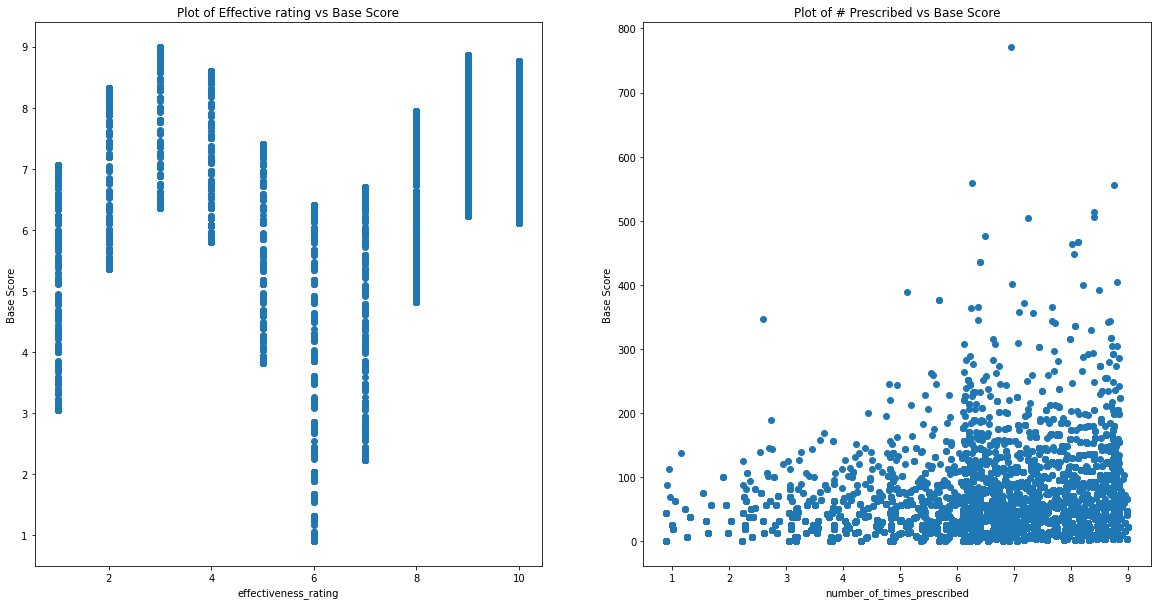

In [78]:
##### Hyporthesis 1  : effectiveness_rating and #_prescribed relation with base_score.

fig = plt.figure(figsize = (20,10))
fig.patch.set_facecolor('white')

ax1 = fig.add_subplot(121)
ax1.scatter(train['effectiveness_rating'],y = train['base_score'])
plt.title('Plot of Effective rating vs Base Score')
plt.xlabel('effectiveness_rating')
plt.ylabel('Base Score')

ax2 = fig.add_subplot(122)
ax2.scatter(train['base_score'],y = train['number_of_times_prescribed'])
plt.title('Plot of # Prescribed vs Base Score')
plt.xlabel('number_of_times_prescribed')
plt.ylabel('Base Score')

plt.show()

Observation 1 : Effective rating of 6 have high spread of base_score with values going as low as 1. This is not seen in cases where effective rating is low (ex. 1). rating 3,4,8,9,10 have scores avg above 6.

Observation 2: We can see in second plot that as the number of times prescribed increases the base_score also increases. They shoe somewhat linear relation.

In [84]:
##### Min/Max dates in train and test
print('Min approved date in train : {0}'.format(train['Date_New'].min()))
print('Max approved date in train : {0}'.format(train['Date_New'].max()))
print('Min approved date in test : {0}'.format(test['Date_New'].min()))
print('Max approved date in test : {0}'.format(test['Date_New'].max()))

Min approved date in train : 2008-02-24 00:00:00
Max approved date in train : 2017-12-12 00:00:00
Min approved date in test : 2008-02-25 00:00:00
Max approved date in test : 2017-12-12 00:00:00


In [87]:
################ Drugs overlap in train and test
drug_train = set(train['name_of_drug'])
drug_test = set(test['name_of_drug'])

print('Total unique drugs in train : %s and test: %s.' % (len(drug_train),len(drug_test)))
print('Common drugs in train and test  :%s' % (len(drug_train.intersection(drug_test))))
print('Number of drugs in train but not in test : %s' % (len(drug_train.difference(drug_test))))
print('Number of drugs in test but not in train : %s'  % (len(drug_test.difference(drug_train))))

Total unique drugs in train : 2220 and test: 1478.
Common drugs in train and test  :1317
Number of drugs in train but not in test : 903
Number of drugs in test but not in train : 161


In [88]:
train.head()

,patient_id,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,drug_approved_by_UIC,number_of_times_prescribed,base_score,Date_New
13676,70730,Abacavir / dolutegravir / lamivudine,HIV Infection,"""I recently found out about my positive status...",7,3-Jan-15,26,3.471857,2015-01-03
30959,70750,Abacavir / dolutegravir / lamivudine,HIV Infection,"""Update: After being on Triumeq a little over ...",10,23-Sep-15,12,6.355866,2015-09-23
22442,70746,Abacavir / dolutegravir / lamivudine,HIV Infection,"""I got diagnosis very early, within 7 days aft...",10,28-Oct-15,12,6.355866,2015-10-28
22154,70735,Abacavir / dolutegravir / lamivudine,HIV Infection,"""I have been on triumeq for over 3 months now ...",10,25-Feb-16,11,7.544493,2016-02-25
966,70726,Abacavir / dolutegravir / lamivudine,HIV Infection,"""I went straight on Triumeq a couple of months...",10,20-Mar-16,13,6.256624,2016-03-20
